In [1]:
import numpy as np
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

# From https://hackl.science/pyre/_modules/pyre/cholesky.html

def computeCholeskyDecomposition(self):
    Ro = self.model.getModifiedCorrelation()
    Lo, ierr = CholeskyDecomposition(Ro)
    if  ierr > 0:
        print('Error: Cholesky decomposition', ierr)
    self.model.setLowerTriangularMatrix(Lo)
    iLo = np.linalg.inv(Lo)
    self.model.setInvLowerTriangularMatrix(iLo)

def CholeskyDecomposition(A):
    n,n = A.shape
    ierr = 0
    for k in range(n):
        if A[k][k] <= 0:
            ierr = k
            print('CholeskyDecomposition Error: Matrix must be positive definite\n')
            break
        A[k][k] = np.sqrt(A[k][k])
        indx = list(range(k+1,n))
        for i in indx:
            A[i][k] = A[i][k] * A[k][k]**(-1)
        for j in range(k+1,n):
            indx = list(range(j,n))
            for i in indx:
                A[i][j] = A[i][j] - A[i][k]*A[j][k]
    Lo = np.tril(A)
    return Lo, ierr

In [2]:
# Set off infinitesimally small values in M to 0
# Useful when there are inconsequential complex parts in M
def remove_small_values(M):
    M1 = np.array(M, dtype='float')
    M2 = np.array(M, dtype='complex_')
    has_complex = False
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            r, x = (M[i,j].real, M[i,j].imag)
            if r < 0.0001:
                r = 0
            if x < 0.0001:
                x = 0
            else:
                has_complex = True
            M2[i,j] = r + x*1j
            M1[i,j] = r
    if has_complex:
        return M2
    return M1

In [12]:
#X = np.array([[1.,0.],[0.,1.],[1.,1.],[0.,0.]])
#X = np.array([[1.,0.],[5.,1.],[3.,2.],[4.,5.],[8.,1.]])
X = np.array([[1.,0.],[5.,1.],[3.,2.],[4.,5.],[8.,1.],[5.,4.],[3.,5.]])

Xc = X - np.outer(np.ones(X.shape[0]), np.mean(X, axis=0))

B = np.dot(Xc, Xc.T)
B

array([[16.490, 1.347, 5.061, -5.796, -8.082, -6.367, -2.653],
       [1.347, 3.204, -0.082, -3.939, 5.776, -1.510, -4.796],
       [5.061, -0.082, 1.633, -1.224, -3.510, -1.796, -0.082],
       [-5.796, -3.939, -1.224, 5.918, -4.367, 3.347, 6.061],
       [-8.082, 5.776, -3.510, -4.367, 17.347, 1.061, -8.224],
       [-6.367, -1.510, -1.796, 3.347, 1.061, 2.776, 2.490],
       [-2.653, -4.796, -0.082, 6.061, -8.224, 2.490, 7.204]])

### Cholesky decomposition on gramian directly from centered data

In [13]:
import pyre

C = pyre.cholesky.CholeskyDecomposition(B.copy())
vectors = C[0]
vector_lengths = np.array([np.linalg.norm(vectors[:,i]) for i in range(vectors.shape[1])])

idx = vector_lengths.argsort()[::-1]
vectors = vectors[:,idx]

# Check if the factorization is correct
print("B=\n", B)
print()
print("XX^T=\n", np.dot(vectors, vectors.T))

XX1 = vectors[:,:Xc.shape[1]]

Error: in Choleski decomposition - Matrix must be positive definite

B=
 [[16.490 1.347 5.061 -5.796 -8.082 -6.367 -2.653]
 [1.347 3.204 -0.082 -3.939 5.776 -1.510 -4.796]
 [5.061 -0.082 1.633 -1.224 -3.510 -1.796 -0.082]
 [-5.796 -3.939 -1.224 5.918 -4.367 3.347 6.061]
 [-8.082 5.776 -3.510 -4.367 17.347 1.061 -8.224]
 [-6.367 -1.510 -1.796 3.347 1.061 2.776 2.490]
 [-2.653 -4.796 -0.082 6.061 -8.224 2.490 7.204]]

XX^T=
 [[16.490 1.347 5.061 -5.796 -8.082 -6.367 -2.653]
 [1.347 3.204 -0.082 -3.939 5.776 -1.510 -4.796]
 [5.061 -0.082 1.633 -1.224 -3.510 -1.796 -0.082]
 [-5.796 -3.939 -1.224 5.918 -4.367 3.347 6.061]
 [-8.082 5.776 -3.510 -4.367 17.347 1.061 -8.224]
 [-6.367 -1.510 -1.796 3.347 1.061 2.776 2.490]
 [-2.653 -4.796 -0.082 6.061 -8.224 2.490 7.204]]


### Eigendecomposition on gramian directly from centered data

In [14]:
eigenvalues, eigenvectors = np.linalg.eig(B.copy())
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Check if the factorization is correct
print("B=\n", B)
print()
E = np.zeros(eigenvectors.shape)
np.fill_diagonal(E, eigenvalues)
print("XUX^T=\n", np.dot(np.dot(eigenvectors, E), eigenvectors.T))

Y = np.zeros(eigenvectors.shape)
np.fill_diagonal(Y, np.sqrt(eigenvalues))
XX2 = np.dot(eigenvectors, Y)

B=
 [[16.490 1.347 5.061 -5.796 -8.082 -6.367 -2.653]
 [1.347 3.204 -0.082 -3.939 5.776 -1.510 -4.796]
 [5.061 -0.082 1.633 -1.224 -3.510 -1.796 -0.082]
 [-5.796 -3.939 -1.224 5.918 -4.367 3.347 6.061]
 [-8.082 5.776 -3.510 -4.367 17.347 1.061 -8.224]
 [-6.367 -1.510 -1.796 3.347 1.061 2.776 2.490]
 [-2.653 -4.796 -0.082 6.061 -8.224 2.490 7.204]]

XUX^T=
 [[16.48979592+0.j  1.34693878+0.j  5.06122449+0.j -5.79591837+0.j
  -8.08163265+0.j -6.36734694+0.j -2.65306122+0.j]
 [ 1.34693878+0.j  3.20408163+0.j -0.08163265+0.j -3.93877551+0.j
   5.7755102 +0.j -1.51020408+0.j -4.79591837+0.j]
 [ 5.06122449+0.j -0.08163265+0.j  1.63265306+0.j -1.2244898 +0.j
  -3.51020408+0.j -1.79591837+0.j -0.08163265+0.j]
 [-5.79591837+0.j -3.93877551+0.j -1.2244898 +0.j  5.91836735+0.j
  -4.36734694+0.j  3.34693878+0.j  6.06122449+0.j]
 [-8.08163265+0.j  5.7755102 +0.j -3.51020408+0.j -4.36734694+0.j
  17.34693878+0.j  1.06122449+0.j -8.2244898 +0.j]
 [-6.36734694+0.j -1.51020408+0.j -1.79591837+0.j  3.346

c:\users\surface\miniconda3\lib\site-packages\numpy\lib\index_tricks.py:899: ComplexWarning: Casting complex values to real discards the imaginary part
  a.flat[:end:step] = val


### Plot side-by-side

c:\users\surface\miniconda3\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


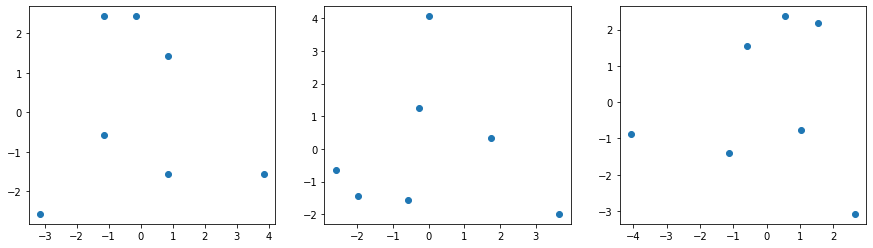

[[0.000 4.123 2.828 5.831 7.071 5.657 5.385]
 [4.123 0.000 2.236 4.123 3.000 3.000 4.472]
 [2.828 2.236 0.000 3.162 5.099 2.828 3.000]
 [5.831 4.123 3.162 0.000 5.657 1.414 1.000]
 [7.071 3.000 5.099 5.657 0.000 4.243 6.403]
 [5.657 3.000 2.828 1.414 4.243 0.000 2.236]
 [5.385 4.472 3.000 1.000 6.403 2.236 0.000]]

[[0.000 4.123 2.828 5.831 7.071 5.657 5.385]
 [4.123 0.000 2.236 4.123 3.000 3.000 4.472]
 [2.828 2.236 0.000 3.162 5.099 2.828 3.000]
 [5.831 4.123 3.162 0.000 5.657 1.414 1.000]
 [7.071 3.000 5.099 5.657 0.000 4.243 6.403]
 [5.657 3.000 2.828 1.414 4.243 0.000 2.236]
 [5.385 4.472 3.000 1.000 6.403 2.236 0.000]]

[[0.000 4.123 2.828 5.831 7.071 5.657 5.385]
 [4.123 0.000 2.236 4.123 3.000 3.000 4.472]
 [2.828 2.236 0.000 3.162 5.099 2.828 3.000]
 [5.831 4.123 3.162 0.000 5.657 1.414 1.000]
 [7.071 3.000 5.099 5.657 0.000 4.243 6.403]
 [5.657 3.000 2.828 1.414 4.243 0.000 2.236]
 [5.385 4.472 3.000 1.000 6.403 2.236 0.000]]


c:\users\surface\miniconda3\lib\site-packages\numpy\core\_asarray.py:228: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order='C', ndmin=1)


In [15]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot side-by-side
ax1.scatter(Xc[:,0], Xc[:,1])
ax2.scatter(XX1[:,0], XX1[:,1])
ax3.scatter(XX2[:,0], XX2[:,1])
plt.show()

# Recompute pairwise distances from both solutions
print(squareform(pdist(Xc)))
print()
print(squareform(pdist(XX1[:,:2])))
print()
print(squareform(pdist(XX2[:,:2])))

### Gramian from distance matrix 

In [16]:
D = squareform(pdist(X))

# Compute Gramian from D
A = -(1/2)*D**2
C = np.identity(D.shape[0]) - np.ones((D.shape[0], D.shape[0]))/D.shape[0]
B = np.dot(np.dot(C,A),C)

### Cholesky factorization on Grammian from distance matrix

In [17]:
C = CholeskyDecomposition(B.copy())
vectors = C[0]
vector_lengths = np.array([np.linalg.norm(vectors[:,i]) for i in range(vectors.shape[1])])
idx = vector_lengths.argsort()[::-1]
vectors = vectors[:,idx]

# Check if the factorization is correct
print("B=\n", B)
print()
print("XX^T=\n", np.dot(vectors, vectors.T))

XX1 = vectors[:,:X.shape[1]]

CholeskyDecomposition Error: Matrix must be positive definite

B=
 [[16.490 1.347 5.061 -5.796 -8.082 -6.367 -2.653]
 [1.347 3.204 -0.082 -3.939 5.776 -1.510 -4.796]
 [5.061 -0.082 1.633 -1.224 -3.510 -1.796 -0.082]
 [-5.796 -3.939 -1.224 5.918 -4.367 3.347 6.061]
 [-8.082 5.776 -3.510 -4.367 17.347 1.061 -8.224]
 [-6.367 -1.510 -1.796 3.347 1.061 2.776 2.490]
 [-2.653 -4.796 -0.082 6.061 -8.224 2.490 7.204]]

XX^T=
 [[16.490 1.347 5.061 -5.796 -8.082 -6.367 -2.653]
 [1.347 3.204 -0.082 -3.939 5.776 -1.510 -4.796]
 [5.061 -0.082 1.633 -1.224 -3.510 -1.796 -0.082]
 [-5.796 -3.939 -1.224 5.918 -4.367 3.347 6.061]
 [-8.082 5.776 -3.510 -4.367 17.347 1.061 -8.224]
 [-6.367 -1.510 -1.796 3.347 1.061 2.776 2.490]
 [-2.653 -4.796 -0.082 6.061 -8.224 2.490 7.204]]


### Eigendecomposition on distance matrix only (MDS)

In [20]:
eigenvalues, eigenvectors = np.linalg.eig(B.copy())
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Check if the factorization is correct
print("B=\n", B)
print()
E = np.zeros(eigenvectors.shape)
np.fill_diagonal(E, eigenvalues)
print("XUX^T=\n", np.dot(np.dot(eigenvectors, E), eigenvectors.T))

Y = np.zeros((len(eigenvalues),len(eigenvalues)))
np.fill_diagonal(Y, eigenvalues**(0.5))
XX2 = np.dot(eigenvectors, Y)

B=
 [[16.490 1.347 5.061 -5.796 -8.082 -6.367 -2.653]
 [1.347 3.204 -0.082 -3.939 5.776 -1.510 -4.796]
 [5.061 -0.082 1.633 -1.224 -3.510 -1.796 -0.082]
 [-5.796 -3.939 -1.224 5.918 -4.367 3.347 6.061]
 [-8.082 5.776 -3.510 -4.367 17.347 1.061 -8.224]
 [-6.367 -1.510 -1.796 3.347 1.061 2.776 2.490]
 [-2.653 -4.796 -0.082 6.061 -8.224 2.490 7.204]]

XUX^T=
 [[16.490 1.347 5.061 -5.796 -8.082 -6.367 -2.653]
 [1.347 3.204 -0.082 -3.939 5.776 -1.510 -4.796]
 [5.061 -0.082 1.633 -1.224 -3.510 -1.796 -0.082]
 [-5.796 -3.939 -1.224 5.918 -4.367 3.347 6.061]
 [-8.082 5.776 -3.510 -4.367 17.347 1.061 -8.224]
 [-6.367 -1.510 -1.796 3.347 1.061 2.776 2.490]
 [-2.653 -4.796 -0.082 6.061 -8.224 2.490 7.204]]


c:\users\surface\miniconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


### Plot side-by-side

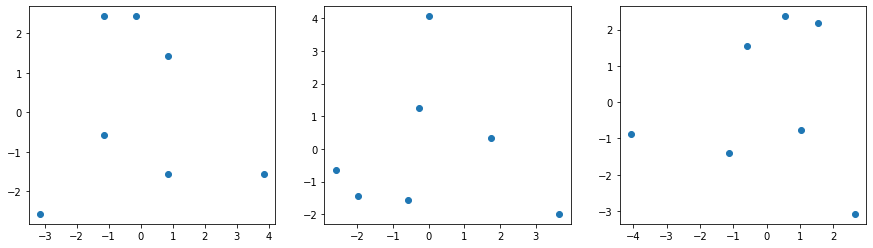

[[0.000 4.123 2.828 5.831 7.071 5.657 5.385]
 [4.123 0.000 2.236 4.123 3.000 3.000 4.472]
 [2.828 2.236 0.000 3.162 5.099 2.828 3.000]
 [5.831 4.123 3.162 0.000 5.657 1.414 1.000]
 [7.071 3.000 5.099 5.657 0.000 4.243 6.403]
 [5.657 3.000 2.828 1.414 4.243 0.000 2.236]
 [5.385 4.472 3.000 1.000 6.403 2.236 0.000]]

[[0.000 4.123 2.828 5.831 7.071 5.657 5.385]
 [4.123 0.000 2.236 4.123 3.000 3.000 4.472]
 [2.828 2.236 0.000 3.162 5.099 2.828 3.000]
 [5.831 4.123 3.162 0.000 5.657 1.414 1.000]
 [7.071 3.000 5.099 5.657 0.000 4.243 6.403]
 [5.657 3.000 2.828 1.414 4.243 0.000 2.236]
 [5.385 4.472 3.000 1.000 6.403 2.236 0.000]]

[[0.000 4.123 2.828 5.831 7.071 5.657 5.385]
 [4.123 0.000 2.236 4.123 3.000 3.000 4.472]
 [2.828 2.236 0.000 3.162 5.099 2.828 3.000]
 [5.831 4.123 3.162 0.000 5.657 1.414 1.000]
 [7.071 3.000 5.099 5.657 0.000 4.243 6.403]
 [5.657 3.000 2.828 1.414 4.243 0.000 2.236]
 [5.385 4.472 3.000 1.000 6.403 2.236 0.000]]


In [21]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot side-by-side
ax1.scatter(Xc[:,0], Xc[:,1])
ax2.scatter(XX1[:,0], XX1[:,1])
ax3.scatter(XX2[:,0], XX2[:,1])
plt.show()

# Recompute pairwise distances from both solutions
print(squareform(pdist(Xc)))
print()
print(squareform(pdist(XX1[:,:2])))
print()
print(squareform(pdist(XX2[:,:2])))